## Problem Statement 

Build a model that is able to classify customer complaints based on the products/services. By doing so, tickets can be segregated into their relevant categories and, therefore, help in the quick resolution of the issue.

Topic modelling is to be done on the <b>.json</b> data provided by the company. Since this data is not labelled, yNMF is to be applied to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, each ticket should be mapped onto its respective department/category. This data can be used to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, any new customer complaint supprt ticket into its relevant department.

## Pipelines that needs to be performed:


1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file and load it 
f = "D:\\NLP-Semantic Processing\\ticket_classification\\complaints-2021-05-14_08_16.json"# Write the path to your data 
 

In [3]:
with open(f, 'r') as file:
    data = json.load(file)
# returns JSON object as  a dictionary 

df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#checking a typical entry
for column in df.columns:
    print(column, ":\t",df[column][2],"\n")

_index :	 complaint-public-v2 

_type :	 complaint 

_id :	 3199379 

_score :	 0.0 

_source.tags :	 None 

_source.zip_code :	 77069 

_source.complaint_id :	 3199379 

_source.issue :	 Other features, terms, or problems 

_source.date_received :	 2019-04-02T12:00:00-05:00 

_source.state :	 TX 

_source.consumer_disputed :	 N/A 

_source.product :	 Credit card or prepaid card 

_source.company_response :	 Closed with explanation 

_source.company :	 JPMORGAN CHASE & CO. 

_source.submitted_via :	 Web 

_source.date_sent_to_company :	 2019-04-02T12:00:00-05:00 

_source.company_public_response :	 None 

_source.sub_product :	 General-purpose credit card or charge card 

_source.timely :	 Yes 

_source.complaint_what_happened :	 I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/X

### Observation: Customer complaint is recoreded in the field "_source.complaint_what_happened". If this field is empty, those corresponding rows can be omitted as empty values for that field wont help to achieve the purpose.

### EDA

### Checking if the columns _source.complaint_id and _id are same for all rows, if yes, can be removed

In [7]:
if (sum([1 for i in df.index if df.loc[i, "_id"] == df.loc[i, "_source.complaint_id"]]) == len(df)):
    print("yes, both columns are same")
else:
    print("no")

yes, both columns are same


### Therefore any one of these columns can be dropped

In [8]:
df = df.drop('_source.complaint_id', axis=1)

In [9]:
col_list = df.columns

Making a list of columns for further use

In [10]:
col_list

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.issue', '_source.date_received', '_source.state',
       '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

Trimming the column names to only minimal to show the intention of the title

In [11]:
col_list = [col.replace("_source.","") for col in col_list]

In [12]:
col_list = [col.replace("_","") for col in col_list]

In [13]:
col_list

['index',
 'type',
 'id',
 'score',
 'tags',
 'zipcode',
 'issue',
 'datereceived',
 'state',
 'consumerdisputed',
 'product',
 'companyresponse',
 'company',
 'submittedvia',
 'datesenttocompany',
 'companypublicresponse',
 'subproduct',
 'timely',
 'complaintwhathappened',
 'subissue',
 'consumerconsentprovided']

The above column names are less complex and easier to understand.

The new column names are assigned to the dataframe columns

In [14]:
df.columns = col_list

In [15]:
df.head()

,index,type,id,score,tags,zipcode,issue,datereceived,state,consumerdisputed,...,companyresponse,company,submittedvia,datesenttocompany,companypublicresponse,subproduct,timely,complaintwhathappened,subissue,consumerconsentprovided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


Checking typical entry

In [16]:
#checking a typical entry
for column in df.columns:
    print(column, ":\t",df[column][2],"\n")

index :	 complaint-public-v2 

type :	 complaint 

id :	 3199379 

score :	 0.0 

tags :	 None 

zipcode :	 77069 

issue :	 Other features, terms, or problems 

datereceived :	 2019-04-02T12:00:00-05:00 

state :	 TX 

consumerdisputed :	 N/A 

product :	 Credit card or prepaid card 

companyresponse :	 Closed with explanation 

company :	 JPMORGAN CHASE & CO. 

submittedvia :	 Web 

datesenttocompany :	 2019-04-02T12:00:00-05:00 

companypublicresponse :	 None 

subproduct :	 General-purpose credit card or charge card 

timely :	 Yes 

complaintwhathappened :	 I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me. 

subissue :	 Problem with rewards from credit card 

consumerconsentprovid

changing the name of the column with the complaint to an easier one -just 'complaints'

In [17]:
#changing the name of the column with the complaint to an easier one.
df.rename(columns={'complaintwhathappened': 'complaints'}, inplace=True)

In [18]:
#checking a typical entry
for column in df.columns:
    print(column, ":\t",df[column][2],"\n")

index :	 complaint-public-v2 

type :	 complaint 

id :	 3199379 

score :	 0.0 

tags :	 None 

zipcode :	 77069 

issue :	 Other features, terms, or problems 

datereceived :	 2019-04-02T12:00:00-05:00 

state :	 TX 

consumerdisputed :	 N/A 

product :	 Credit card or prepaid card 

companyresponse :	 Closed with explanation 

company :	 JPMORGAN CHASE & CO. 

submittedvia :	 Web 

datesenttocompany :	 2019-04-02T12:00:00-05:00 

companypublicresponse :	 None 

subproduct :	 General-purpose credit card or charge card 

timely :	 Yes 

complaints :	 I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me. 

subissue :	 Problem with rewards from credit card 

consumerconsentprovided :	 Conse

### Checking extent of empty texts in comlaints column

In [19]:
(df['complaints'] == '').sum()

57241

In [20]:
len(df)


78313

### 57241 out of 78313 nos of entries have empty texts, which is a substantial 73.1%. still the remaining 26.9% would be enough to train a model for classification. This amounts to 21067 nos which is not at all a small number

In [21]:
#Assign nan in place of blanks in the complaints column
df['complaints'].replace('', np.nan, inplace=True)

In [22]:
(df['complaints'] == '').sum()

0

In [23]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaints'])

the dataframe now has only those entries with the complaint column non-empty

In [24]:
len(df)

21072

## Prepare the text for topic modeling

Now that the empty complaint rows are removed, the complaint text is to be pre-processed- basically cleaning and lexical/syntactic processing

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once the cleaning operations are done the following needs to performed :
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"]. This is done since the tag NN carries more relevant info. removing other words can make the computations less intensive


In [25]:
# Function here to clean the text and remove all the unnecessary elements.
import re

def clean_text(text):
    brackets_removed = re.sub(r'\[.*?\]', '', text)
    numbers_removed = re.sub(r'\w*\d\w*', '', brackets_removed)
    punctuations_removed = re.sub(r'[^\w\s]', '', numbers_removed)
    combine_spaces = re.sub(r'\s+', ' ', punctuations_removed)
    cleaned = combine_spaces.lower()

    return cleaned


Testing the clean text function

In [26]:
clean_text("THIS is a test to check cleaning of word456, 123word, 123word123, word123word, exclaims!, [text ins squares], ][")

'this is a test to check cleaning of exclaims '

In [27]:
# function to Lemmatize the texts
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]

    return lemmatized


Testing the lemmatizing function on the cleaned text

In [28]:
lemmatize_text(clean_text("THIS is a test to check cleaning of \{ word456 \}, 123word, 123word123, word123word, exclaims!, [text ins squares], ]["))

['this', 'is', 'a', 'test', 'to', 'check', 'cleaning', 'of', 'exclaims']

In [29]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaints'] = df['complaints']
df_clean['lemm_complaints'] = df['complaints'].apply(lambda text: lemmatize_text(clean_text(text)))



In [30]:
df_clean

,complaints,lemm_complaints
1,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xxxx, ..."
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, xxxx, however,..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","[on, xxxx, while, trying, to, book, a, xxxx, x..."
14,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo..."
...,...,...
78303,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ..."
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,..."
78310,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d..."
78311,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, yr, ive,..."


Downloading the necessary data for POS tagging

In [31]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

trying our various splitting options

In [32]:
sent = "THIS is a test to check cleaning of word456, 123word, 123word123, word123word, exclaims!, [text ins squares], ]["
sent.split()

['THIS',
 'is',
 'a',
 'test',
 'to',
 'check',
 'cleaning',
 'of',
 'word456,',
 '123word,',
 '123word123,',
 'word123word,',
 'exclaims!,',
 '[text',
 'ins',
 'squares],',
 '][']

Trying out Applying NLTK pos tag method on the split sentence to get the POS tags of each word/token

In [33]:
nltk.pos_tag(sent.split())

[('THIS', 'NNP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('test', 'NN'),
 ('to', 'TO'),
 ('check', 'VB'),
 ('cleaning', 'NN'),
 ('of', 'IN'),
 ('word456,', '$'),
 ('123word,', 'CD'),
 ('123word123,', 'CD'),
 ('word123word,', 'NN'),
 ('exclaims!,', 'NN'),
 ('[text', 'JJ'),
 ('ins', 'NNS'),
 ('squares],', 'VBP'),
 ('][', 'NN')]

Trying out the nltk pos_tag method on the cleaned and lemmatized text

In [34]:
nltk.pos_tag(lemmatize_text(clean_text(sent)))

[('this', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('test', 'NN'),
 ('to', 'TO'),
 ('check', 'VB'),
 ('cleaning', 'NN'),
 ('of', 'IN'),
 ('exclaims', 'NNS')]

function to extract the POS tags and removing all words with tags other than "NN"


In [35]:
#function to extract the POS tags and removing all words with tags other than "NN"

def get_pos_tag(word_list):
  return_list=[]
  pos_tags = nltk.pos_tag(word_list)
  for word, tag in pos_tags:
    if tag == "NN":
        return_list.append(word)
  return return_list

Testing lemmatization

In [36]:
lemmatized_text = lemmatize_text(clean_text("THIS is a test to check cleaning of word456, 123word, 123word123, word123word, exclaims!, [text ins squares], ]["))

In [37]:
lemmatized_text

['this', 'is', 'a', 'test', 'to', 'check', 'cleaning', 'of', 'exclaims']

Testing cleaning, lemmatization and extracting POS tags

In [38]:
test_pos = get_pos_tag(lemmatized_text)

In [39]:
test_pos

['test', 'cleaning']

Making a new column "complaint_POS_removed" containing lemmatized text with all words with tags other than "NN" removed

In [40]:
df_clean["complaint_POS_removed"] = df_clean['lemm_complaints'].apply(lambda word_list: get_pos_tag(word_list)) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [41]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemm_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, servic..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xxxx, ...","[i, card, wa, agent, upgrade, date, agent, wa,..."
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, xxxx, however,...","[card, wa, xxxx, application, identity, consen..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","[on, xxxx, while, trying, to, book, a, xxxx, x...","[book, xxxx, ticket, i, offer, ticket, card, i..."
14,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, deposit, chase, account, fund, chase, ba..."
...,...,...,...
78303,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[chase, card, customer, decade, wa, solicitati..."
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,...","[xxxxxxxx, i, chas, visa, credit, card, provid..."
78310,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[i, pay, risk, consumer, i, bank, app, chase, ..."
78311,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, yr, ive,...","[i, credit, credit, card, chase, freedom, xxxx..."


## Exploratory data analysis to get familiar with the data.

perform the following tasks:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




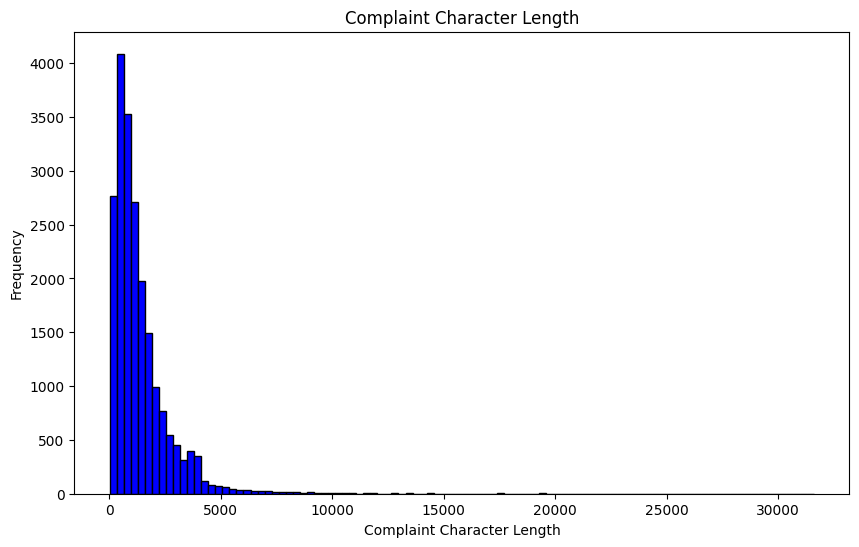

In [42]:
# Code visualise the data according to the 'Complaint' character length

# Create a new column 'Complaint_length' that contains the character length of each complaint
df_clean['Complaint_length'] = df_clean['complaints'].apply(len)
# Plot a histogram of the complaint lengths
plt.figure(figsize=(10,6))
plt.hist(df_clean['Complaint_length'],  bins=100,
         color='b', edgecolor='black')
plt.title('Complaint Character Length')
plt.xlabel('Complaint Character Length')
plt.ylabel('Frequency')
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

can use Counter method from collections library and word cloud library for this

In [43]:
from collections import Counter
from wordcloud import WordCloud

In [44]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
#super_sent = [token.text for token in noun_propn_words]
super_sent = [word for words_list in df_clean['complaint_POS_removed'] for word in words_list]
word_counts = Counter(super_sent)
#Counter method from Collections Library




### Printing the most frequent 40 words, the number of occurrences and the corresponding tags- this will all be "NN"

In [45]:
for word, count in word_counts.most_common(40):
    print(word, "--", count, "--", nltk.pos_tag([word])[0][1])
    #PRints the word, number of occurences in the corpus(training data) and the corresponding PoS

i -- 128204 -- NN
chase -- 51143 -- NN
account -- 47648 -- NN
xxxx -- 43083 -- NN
credit -- 33095 -- NN
wa -- 32961 -- NN
card -- 29592 -- NN
bank -- 28234 -- NN
payment -- 21173 -- NN
time -- 16042 -- NN
xxxxxxxx -- 13238 -- NN
day -- 13191 -- NN
charge -- 12240 -- NN
money -- 11961 -- NN
loan -- 10982 -- NN
check -- 10174 -- NN
letter -- 9680 -- NN
information -- 9654 -- NN
fee -- 8686 -- NN
transaction -- 8650 -- NN
number -- 8605 -- NN
month -- 8509 -- NN
year -- 8375 -- NN
amount -- 8363 -- NN
mortgage -- 8179 -- NN
customer -- 8163 -- NN
ha -- 8160 -- NN
balance -- 7758 -- NN
company -- 7630 -- NN
service -- 7595 -- NN
phone -- 7589 -- NN
report -- 7215 -- NN
fraud -- 7115 -- NN
claim -- 7054 -- NN
fund -- 6980 -- NN
call -- 6927 -- NN
business -- 5595 -- NN
interest -- 5339 -- NN
statement -- 5268 -- NN
home -- 5266 -- NN


### Making a word cloud of most common 40 words using word counts and the library wordcloud

In [46]:
most_common_words = dict(word_counts.most_common(40))

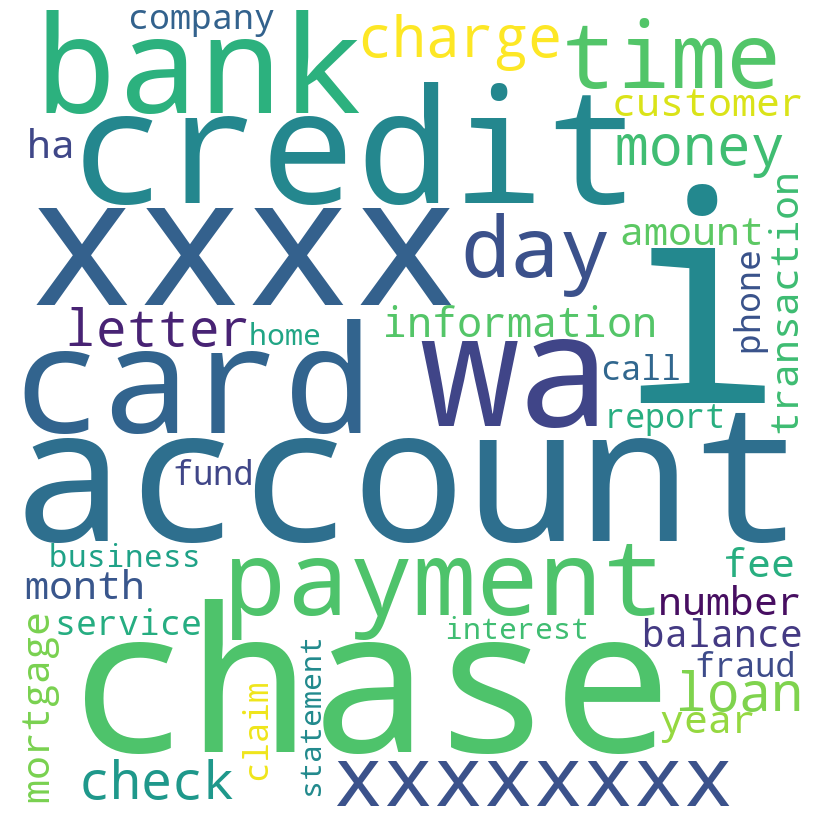

In [47]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 2).generate_from_frequencies(most_common_words)
                   
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [48]:
#Removing -PRON- from the text corpus
#df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].apply(lambda words: [word.replace('-PRON-', '') for word in words])

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

For this ngram method from nltk is utized

In [49]:
from nltk import ngrams
from nltk import word_tokenize

In [50]:
df_clean.head()

,complaints,lemm_complaints,complaint_POS_removed,Complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, servic...",486,"[morning, name, stop, bank, cardmember, servic..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xxxx, ...","[i, card, wa, agent, upgrade, date, agent, wa,...",355,"[i, card, wa, agent, upgrade, date, agent, wa,..."
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, xxxx, however,...","[card, wa, xxxx, application, identity, consen...",224,"[card, wa, xxxx, application, identity, consen..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","[on, xxxx, while, trying, to, book, a, xxxx, x...","[book, xxxx, ticket, i, offer, ticket, card, i...",1502,"[book, xxxx, ticket, i, offer, ticket, card, i..."
14,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, deposit, chase, account, fund, chase, ba...",477,"[son, deposit, chase, account, fund, chase, ba..."


### Top 30 unigrams and the frequency

In [51]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
#df_clean['tokens'] = df_clean['complaints'].apply(word_tokenize)
df_clean['unigrams'] = df_clean['Complaint_clean'].apply(lambda tokens: list(ngrams(tokens, 1)))
unigrams = [unigram for sublist in df_clean['unigrams'] for unigram in sublist]
unigram_freq = Counter(unigrams)
uni_30 = unigram_freq.most_common(30)
uni_30


[(('i',), 128204),
 (('chase',), 51143),
 (('account',), 47648),
 (('xxxx',), 43083),
 (('credit',), 33095),
 (('wa',), 32961),
 (('card',), 29592),
 (('bank',), 28234),
 (('payment',), 21173),
 (('time',), 16042),
 (('xxxxxxxx',), 13238),
 (('day',), 13191),
 (('charge',), 12240),
 (('money',), 11961),
 (('loan',), 10982),
 (('check',), 10174),
 (('letter',), 9680),
 (('information',), 9654),
 (('fee',), 8686),
 (('transaction',), 8650),
 (('number',), 8605),
 (('month',), 8509),
 (('year',), 8375),
 (('amount',), 8363),
 (('mortgage',), 8179),
 (('customer',), 8163),
 (('ha',), 8160),
 (('balance',), 7758),
 (('company',), 7630),
 (('service',), 7595)]

### Printing top 10 words based on unigram frequency

In [52]:
#Print the top 10 words in the unigram frequency
uni_10 = unigram_freq.most_common(10)
for i in range(len(uni_10)):
    print(uni_10[i][0][0])

i
chase
account
xxxx
credit
wa
card
bank
payment
time


### Top 30 bigrams and frequency

In [53]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
#df_clean['tokens'] = df_clean['complaints'].apply(word_tokenize)
df_clean['bigrams'] = df_clean['Complaint_clean'].apply(lambda tokens: list(ngrams(tokens, 2)))
bigrams = [bigram for sublist in df_clean['bigrams'] for bigram in sublist]
bigram_freq = Counter(bigrams)
bi_30 = bigram_freq.most_common(30)
bi_30


[(('credit', 'card'), 12803),
 (('xxxx', 'i'), 7978),
 (('i', 'chase'), 7636),
 (('i', 'i'), 6182),
 (('account', 'i'), 5407),
 (('xxxxxxxx', 'i'), 5148),
 (('i', 'account'), 4207),
 (('xxxx', 'xxxx'), 4175),
 (('credit', 'report'), 3871),
 (('i', 'credit'), 3622),
 (('i', 'bank'), 3600),
 (('i', 'xxxx'), 3531),
 (('card', 'i'), 3453),
 (('i', 'payment'), 3111),
 (('customer', 'service'), 3079),
 (('chase', 'credit'), 2979),
 (('chase', 'bank'), 2816),
 (('chase', 'account'), 2815),
 (('account', 'wa'), 2746),
 (('wa', 'i'), 2715),
 (('chase', 'i'), 2703),
 (('bank', 'account'), 2702),
 (('account', 'chase'), 2287),
 (('i', 'card'), 2264),
 (('payment', 'i'), 2130),
 (('time', 'i'), 2118),
 (('i', 'letter'), 2071),
 (('i', 'wa'), 1963),
 (('account', 'account'), 1877),
 (('i', 'money'), 1731)]

### Printing top 10 bigrams

In [54]:
#Print the top 10 words in the bigram frequency
bi_10 = bigram_freq.most_common(10)
for i in range(len(bi_10)):
    print(bi_10[i][0])

('credit', 'card')
('xxxx', 'i')
('i', 'chase')
('i', 'i')
('account', 'i')
('xxxxxxxx', 'i')
('i', 'account')
('xxxx', 'xxxx')
('credit', 'report')
('i', 'credit')


### Top 30 trigrams and the frequency

In [55]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

#df_clean['tokens'] = df_clean['complaints'].apply(word_tokenize)
df_clean['trigrams'] = df_clean['Complaint_clean'].apply(lambda tokens: list(ngrams(tokens, 3)))
trigram = [trigram for sublist in df_clean['trigrams'] for trigram in sublist]
trigram_freq = Counter(trigram)
tri_30 = trigram_freq.most_common(30)
tri_30

[(('chase', 'credit', 'card'), 2059),
 (('i', 'credit', 'card'), 1685),
 (('credit', 'card', 'i'), 1173),
 (('credit', 'card', 'account'), 1012),
 (('credit', 'card', 'company'), 980),
 (('i', 'customer', 'service'), 743),
 (('xxxx', 'xxxx', 'i'), 740),
 (('credit', 'card', 'chase'), 591),
 (('xxxx', 'i', 'chase'), 570),
 (('i', 'account', 'i'), 516),
 (('inquiry', 'credit', 'report'), 510),
 (('i', 'xxxx', 'i'), 484),
 (('xxxxxxxx', 'i', 'chase'), 478),
 (('i', 'chase', 'credit'), 464),
 (('i', 'chase', 'i'), 426),
 (('account', 'i', 'chase'), 423),
 (('i', 'xxxx', 'xxxx'), 411),
 (('i', 'letter', 'chase'), 404),
 (('i', 'payment', 'i'), 393),
 (('xxxx', 'xxxx', 'xxxx'), 388),
 (('credit', 'reporting', 'agency'), 388),
 (('i', 'chase', 'account'), 386),
 (('credit', 'card', 'credit'), 375),
 (('credit', 'report', 'i'), 370),
 (('i', 'bank', 'account'), 367),
 (('i', 'chase', 'bank'), 366),
 (('bank', 'credit', 'card'), 359),
 (('account', 'i', 'account'), 348),
 (('account', 'credit',

### Printing top 10 trigrams

In [56]:
#Print the top 10 words in the trigram frequency
tri_10 = trigram_freq.most_common(10)
for i in range(len(bi_10)):
    print(tri_10[i][0])

('chase', 'credit', 'card')
('i', 'credit', 'card')
('credit', 'card', 'i')
('credit', 'card', 'account')
('credit', 'card', 'company')
('i', 'customer', 'service')
('xxxx', 'xxxx', 'i')
('credit', 'card', 'chase')
('xxxx', 'i', 'chase')
('i', 'account', 'i')


### It can be observed that a lot if XXXX are present in all the unigrams, bigrams and trigrams. These are basically masking of PII(personally identifiable information). These are not required for modeling and prediction, and removal of those will aid better computational efficiency

### The personal details of customer has been masked in the dataset with xxxx. masked text needs to be removed as this will be of no use for our analysis

In [57]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].apply(lambda words: [word.replace('xxxx', '') for word in words])

In [58]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].apply(lambda x: " ".join(x))

In [59]:
#All masked texts has been removed
df_clean

,complaints,lemm_complaints,complaint_POS_removed,Complaint_length,Complaint_clean,unigrams,bigrams,trigrams
1,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, servic...",486,morning name stop bank cardmember service debt...,"[(morning,), (name,), (stop,), (bank,), (cardm...","[(morning, name), (name, stop), (stop, bank), ...","[(morning, name, stop), (name, stop, bank), (s..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xxxx, ...","[i, card, wa, agent, upgrade, date, agent, wa,...",355,i card wa agent upgrade date agent wa informat...,"[(i,), (card,), (wa,), (agent,), (upgrade,), (...","[(i, card), (card, wa), (wa, agent), (agent, u...","[(i, card, wa), (card, wa, agent), (wa, agent,..."
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, xxxx, however,...","[card, wa, xxxx, application, identity, consen...",224,card wa application identity consent service ...,"[(card,), (wa,), (xxxx,), (application,), (ide...","[(card, wa), (wa, xxxx), (xxxx, application), ...","[(card, wa, xxxx), (wa, xxxx, application), (x..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","[on, xxxx, while, trying, to, book, a, xxxx, x...","[book, xxxx, ticket, i, offer, ticket, card, i...",1502,book ticket i offer ticket card i information...,"[(book,), (xxxx,), (ticket,), (i,), (offer,), ...","[(book, xxxx), (xxxx, ticket), (ticket, i), (i...","[(book, xxxx, ticket), (xxxx, ticket, i), (tic..."
14,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, deposit, chase, account, fund, chase, ba...",477,son deposit chase account fund chase bank acco...,"[(son,), (deposit,), (chase,), (account,), (fu...","[(son, deposit), (deposit, chase), (chase, acc...","[(son, deposit, chase), (deposit, chase, accou..."
...,...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[chase, card, customer, decade, wa, solicitati...",679,chase card customer decade wa solicitation cre...,"[(chase,), (card,), (customer,), (decade,), (w...","[(chase, card), (card, customer), (customer, d...","[(chase, card, customer), (card, customer, dec..."
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,...","[xxxxxxxx, i, chas, visa, credit, card, provid...",2114,i chas visa credit card provider claim purcha...,"[(xxxxxxxx,), (i,), (chas,), (visa,), (credit,...","[(xxxxxxxx, i), (i, chas), (chas, visa), (visa...","[(xxxxxxxx, i, chas), (i, chas, visa), (chas, ..."
78310,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[i, pay, risk, consumer, i, bank, app, chase, ...",2319,i pay risk consumer i bank app chase year mobi...,"[(i,), (pay,), (risk,), (consumer,), (i,), (ba...","[(i, pay), (pay, risk), (risk, consumer), (con...","[(i, pay, risk), (pay, risk, consumer), (risk,..."
78311,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, yr, ive,...","[i, credit, credit, card, chase, freedom, xxxx...",2171,i credit credit card chase freedom problem ba...,"[(i,), (credit,), (credit,), (card,), (chase,)...","[(i, credit), (credit, credit), (credit, card)...","[(i, credit, credit), (credit, credit, card), ..."


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

Use TfIdfvectorizer method from sklearn library

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

Initializing the TfIdfVectorizer

In [61]:
#Code to initialise the TfidfVectorizer 
vect = TfidfVectorizer(max_df=0.95, min_df=2)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [62]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean.Complaint_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

### Use NMF method from sklearn for topic modeling

In [63]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [64]:
#Load  nmf_model with the n_components i.e 5
num_topics = 5 

nmf_model = NMF(n_components=num_topics, random_state=40)

Extracting the W and H

In [65]:
W = nmf_model.fit_transform(X)
H = nmf_model.components_  


Checking the feature lengths-basically the vocabulary size

In [66]:
len(vect.get_feature_names_out())

7133

### Extracting and printing top 15 words for each of the top 5 topics

In [67]:
#Print the Top15 words for each of the topics
words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,fund,chase,wa,deposit,branch,day,fee,checking,business,number,customer
Topic 2,card,credit,chase,balance,account,fee,interest,limit,year,score,month,point,wa,purchase,offer
Topic 3,payment,loan,mortgage,chase,month,modification,home,interest,wa,time,year,rate,balance,amount,property
Topic 4,inquiry,report,credit,bureau,company,information,reporting,debt,identity,score,letter,theft,jpmcb,account,application
Topic 5,charge,transaction,chase,dispute,claim,wa,fraud,merchant,letter,phone,information,time,number,service,call


### Based on the top 15 words and analyzing those words from NMF, topics are assigned as a preliminary measure--these can be changed later after a manual verification

In [68]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_mapping = {
    0: 'Banking account services',
    1: 'Credit card services',
    2: 'Home loan and mortgage services',
    3: 'Others',
    4: 'theft/fraud/dispute',
}

In [69]:
W = pd.DataFrame(W, columns=[i for i in range(num_topics)])

In [70]:
pd.reset_option('display.max_colwidth')

In [71]:
df_clean

,complaints,lemm_complaints,complaint_POS_removed,Complaint_length,Complaint_clean,unigrams,bigrams,trigrams
1,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, servic...",486,morning name stop bank cardmember service debt...,"[(morning,), (name,), (stop,), (bank,), (cardm...","[(morning, name), (name, stop), (stop, bank), ...","[(morning, name, stop), (name, stop, bank), (s..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xxxx, ...","[i, card, wa, agent, upgrade, date, agent, wa,...",355,i card wa agent upgrade date agent wa informat...,"[(i,), (card,), (wa,), (agent,), (upgrade,), (...","[(i, card), (card, wa), (wa, agent), (agent, u...","[(i, card, wa), (card, wa, agent), (wa, agent,..."
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, xxxx, however,...","[card, wa, xxxx, application, identity, consen...",224,card wa application identity consent service ...,"[(card,), (wa,), (xxxx,), (application,), (ide...","[(card, wa), (wa, xxxx), (xxxx, application), ...","[(card, wa, xxxx), (wa, xxxx, application), (x..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","[on, xxxx, while, trying, to, book, a, xxxx, x...","[book, xxxx, ticket, i, offer, ticket, card, i...",1502,book ticket i offer ticket card i information...,"[(book,), (xxxx,), (ticket,), (i,), (offer,), ...","[(book, xxxx), (xxxx, ticket), (ticket, i), (i...","[(book, xxxx, ticket), (xxxx, ticket, i), (tic..."
14,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, deposit, chase, account, fund, chase, ba...",477,son deposit chase account fund chase bank acco...,"[(son,), (deposit,), (chase,), (account,), (fu...","[(son, deposit), (deposit, chase), (chase, acc...","[(son, deposit, chase), (deposit, chase, accou..."
...,...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[chase, card, customer, decade, wa, solicitati...",679,chase card customer decade wa solicitation cre...,"[(chase,), (card,), (customer,), (decade,), (w...","[(chase, card), (card, customer), (customer, d...","[(chase, card, customer), (card, customer, dec..."
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,...","[xxxxxxxx, i, chas, visa, credit, card, provid...",2114,i chas visa credit card provider claim purcha...,"[(xxxxxxxx,), (i,), (chas,), (visa,), (credit,...","[(xxxxxxxx, i), (i, chas), (chas, visa), (visa...","[(xxxxxxxx, i, chas), (i, chas, visa), (chas, ..."
78310,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[i, pay, risk, consumer, i, bank, app, chase, ...",2319,i pay risk consumer i bank app chase year mobi...,"[(i,), (pay,), (risk,), (consumer,), (i,), (ba...","[(i, pay), (pay, risk), (risk, consumer), (con...","[(i, pay, risk), (pay, risk, consumer), (risk,..."
78311,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, yr, ive,...","[i, credit, credit, card, chase, freedom, xxxx...",2171,i credit credit card chase freedom problem ba...,"[(i,), (credit,), (credit,), (card,), (chase,)...","[(i, credit), (credit, credit), (credit, card)...","[(i, credit, credit), (credit, credit, card), ..."


Printing the W matrix

In [72]:
W

,0,1,2,3,4
0,0.023844,0.001417,0.014498,0.017465,0.010167
1,0.011190,0.018335,0.004569,0.000041,0.015306
2,0.000000,0.038452,0.000000,0.020723,0.005189
3,0.019467,0.031738,0.005983,0.040508,0.015852
4,0.063286,0.000000,0.001436,0.000000,0.010759
...,...,...,...,...,...
21067,0.000074,0.099168,0.009701,0.001515,0.020943
21068,0.001863,0.012747,0.000951,0.002791,0.049883
21069,0.011665,0.000000,0.003293,0.028884,0.033096
21070,0.000000,0.077311,0.065123,0.000000,0.000000


Creating a new dataframe with only the max value and the corresponding topic number

In [73]:
max_value = W.max(axis=1)
max_columns = W.idxmax(axis=1)

In [74]:
result_df = pd.DataFrame({
    'Max_Value': max_value,
    'Max_Column': max_columns
})

Max_Column has the corresponding topic number based on the column of occurrence of maximum value

In [75]:
result_df

,Max_Value,Max_Column
0,0.023844,0
1,0.018335,1
2,0.038452,1
3,0.040508,3
4,0.063286,0
...,...,...
21067,0.099168,1
21068,0.049883,4
21069,0.033096,4
21070,0.077311,1


Mapping topics to the numbers

In [76]:
result_df['Topic'] = result_df['Max_Column'].map(topic_mapping)

In [77]:
result_df

,Max_Value,Max_Column,Topic
0,0.023844,0,Banking account services
1,0.018335,1,Credit card services
2,0.038452,1,Credit card services
3,0.040508,3,Others
4,0.063286,0,Banking account services
...,...,...,...
21067,0.099168,1,Credit card services
21068,0.049883,4,theft/fraud/dispute
21069,0.033096,4,theft/fraud/dispute
21070,0.077311,1,Credit card services


Transferring the topics names to df_clean for further processing

In [78]:
df_clean['Topic'] = result_df['Topic'].values

In [79]:
#df_clean['Topic'] = df_clean.index.map(result_df.set_index(result_df.index)['Topic_Name'])

In [80]:
df_clean

,complaints,lemm_complaints,complaint_POS_removed,Complaint_length,Complaint_clean,unigrams,bigrams,trigrams,Topic
1,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, servic...",486,morning name stop bank cardmember service debt...,"[(morning,), (name,), (stop,), (bank,), (cardm...","[(morning, name), (name, stop), (stop, bank), ...","[(morning, name, stop), (name, stop, bank), (s...",Banking account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xxxx, ...","[i, card, wa, agent, upgrade, date, agent, wa,...",355,i card wa agent upgrade date agent wa informat...,"[(i,), (card,), (wa,), (agent,), (upgrade,), (...","[(i, card), (card, wa), (wa, agent), (agent, u...","[(i, card, wa), (card, wa, agent), (wa, agent,...",Credit card services
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, xxxx, however,...","[card, wa, xxxx, application, identity, consen...",224,card wa application identity consent service ...,"[(card,), (wa,), (xxxx,), (application,), (ide...","[(card, wa), (wa, xxxx), (xxxx, application), ...","[(card, wa, xxxx), (wa, xxxx, application), (x...",Credit card services
11,"On XX/XX/2018, while trying to book a XXXX XX...","[on, xxxx, while, trying, to, book, a, xxxx, x...","[book, xxxx, ticket, i, offer, ticket, card, i...",1502,book ticket i offer ticket card i information...,"[(book,), (xxxx,), (ticket,), (i,), (offer,), ...","[(book, xxxx), (xxxx, ticket), (ticket, i), (i...","[(book, xxxx, ticket), (xxxx, ticket, i), (tic...",Others
14,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, deposit, chase, account, fund, chase, ba...",477,son deposit chase account fund chase bank acco...,"[(son,), (deposit,), (chase,), (account,), (fu...","[(son, deposit), (deposit, chase), (chase, acc...","[(son, deposit, chase), (deposit, chase, accou...",Banking account services
...,...,...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[chase, card, customer, decade, wa, solicitati...",679,chase card customer decade wa solicitation cre...,"[(chase,), (card,), (customer,), (decade,), (w...","[(chase, card), (card, customer), (customer, d...","[(chase, card, customer), (card, customer, dec...",Credit card services
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,...","[xxxxxxxx, i, chas, visa, credit, card, provid...",2114,i chas visa credit card provider claim purcha...,"[(xxxxxxxx,), (i,), (chas,), (visa,), (credit,...","[(xxxxxxxx, i), (i, chas), (chas, visa), (visa...","[(xxxxxxxx, i, chas), (i, chas, visa), (chas, ...",theft/fraud/dispute
78310,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[i, pay, risk, consumer, i, bank, app, chase, ...",2319,i pay risk consumer i bank app chase year mobi...,"[(i,), (pay,), (risk,), (consumer,), (i,), (ba...","[(i, pay), (pay, risk), (risk, consumer), (con...","[(i, pay, risk), (pay, risk, consumer), (risk,...",theft/fraud/dispute
78311,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, yr, ive,...","[i, credit, credit, card, chase, freedom, xxxx...",2171,i credit credit card chase freedom problem ba...,"[(i,), (credit,), (credit,), (card,), (chase,)...","[(i, credit), (credit, credit), (credit, card)...","[(i, credit, credit), (credit, credit, card), ...",Credit card services


In [81]:
pd.reset_option('display.max_colwidth')

### Making a new dataframe to check complaints and the corresponding topic names

In [82]:
#Print the first 5 Complaint for each of the Topics
df_check = df_clean[['complaints', 'Topic']]
df_check=df_check.groupby('Topic').head(5)
df_check.sort_values('Topic')

,complaints,Topic
1,Good morning my name is XXXX XXXX and I apprec...,Banking account services
24,mishandling of this account by Chase auto and ...,Banking account services
17,With out notice J.P. Morgan Chase restricted m...,Banking account services
14,my grand son give me check for {$1600.00} i de...,Banking account services
27,I opened an account with chase bank on XXXX an...,Banking account services
10,Chase Card was reported on XX/XX/2019. However...,Credit card services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card services
32,My chase amazon card was declined for a cateri...,Credit card services
52,My roommate was stealing my Chase debit card a...,Credit card services
50,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,Credit card services


In [83]:
df_check.head()

,complaints,Topic
1,Good morning my name is XXXX XXXX and I apprec...,Banking account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card services
10,Chase Card was reported on XX/XX/2019. However...,Credit card services
11,"On XX/XX/2018, while trying to book a XXXX XX...",Others
14,my grand son give me check for {$1600.00} i de...,Banking account services


#### After evaluating the mapping, it is found that the topics assigned are generally ok. Rename the topics as per client's requirement
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [84]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    'Banking account services':'Bank Account Services',
    'Credit card services':'Credit card or prepaid card',
    'Home loan and mortgage services':'Mortgage/Loan',
    'Others':'Others',
    'theft/fraud/dispute':'Theft/Dispute Reporting'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [85]:
df_clean.head()

,complaints,lemm_complaints,complaint_POS_removed,Complaint_length,Complaint_clean,unigrams,bigrams,trigrams,Topic
1,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, servic...",486,morning name stop bank cardmember service debt...,"[(morning,), (name,), (stop,), (bank,), (cardm...","[(morning, name), (name, stop), (stop, bank), ...","[(morning, name, stop), (name, stop, bank), (s...",Bank Account Services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xxxx, ...","[i, card, wa, agent, upgrade, date, agent, wa,...",355,i card wa agent upgrade date agent wa informat...,"[(i,), (card,), (wa,), (agent,), (upgrade,), (...","[(i, card), (card, wa), (wa, agent), (agent, u...","[(i, card, wa), (card, wa, agent), (wa, agent,...",Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, xxxx, however,...","[card, wa, xxxx, application, identity, consen...",224,card wa application identity consent service ...,"[(card,), (wa,), (xxxx,), (application,), (ide...","[(card, wa), (wa, xxxx), (xxxx, application), ...","[(card, wa, xxxx), (wa, xxxx, application), (x...",Credit card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XX...","[on, xxxx, while, trying, to, book, a, xxxx, x...","[book, xxxx, ticket, i, offer, ticket, card, i...",1502,book ticket i offer ticket card i information...,"[(book,), (xxxx,), (ticket,), (i,), (offer,), ...","[(book, xxxx), (xxxx, ticket), (ticket, i), (i...","[(book, xxxx, ticket), (xxxx, ticket, i), (tic...",Others
14,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, deposit, chase, account, fund, chase, ba...",477,son deposit chase account fund chase bank acco...,"[(son,), (deposit,), (chase,), (account,), (fu...","[(son, deposit), (deposit, chase), (chase, acc...","[(son, deposit, chase), (deposit, chase, accou...",Bank Account Services


### Creating a supervised model to predict any new complaints to the relevant Topics.

Build multiple models to create the topics for each complaints.Choose the one with the best accuracy metric to predict the complaint class based on the complaints text from the customer.

Since supervised learning technique will be used topic names will have to be converted to numbers(numpy arrays only understand numbers)

In [86]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank Account Services': 0,
    'Credit card or prepaid card': 1,
    'Mortgage/Loan': 2,
    'Others': 3,
    'Theft/Dispute Reporting': 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [87]:
df_clean

,complaints,lemm_complaints,complaint_POS_removed,Complaint_length,Complaint_clean,unigrams,bigrams,trigrams,Topic
1,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[morning, name, stop, bank, cardmember, servic...",486,morning name stop bank cardmember service debt...,"[(morning,), (name,), (stop,), (bank,), (cardm...","[(morning, name), (name, stop), (stop, bank), ...","[(morning, name, stop), (name, stop, bank), (s...",0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, xxxx, ...","[i, card, wa, agent, upgrade, date, agent, wa,...",355,i card wa agent upgrade date agent wa informat...,"[(i,), (card,), (wa,), (agent,), (upgrade,), (...","[(i, card), (card, wa), (wa, agent), (agent, u...","[(i, card, wa), (card, wa, agent), (wa, agent,...",1
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, xxxx, however,...","[card, wa, xxxx, application, identity, consen...",224,card wa application identity consent service ...,"[(card,), (wa,), (xxxx,), (application,), (ide...","[(card, wa), (wa, xxxx), (xxxx, application), ...","[(card, wa, xxxx), (wa, xxxx, application), (x...",1
11,"On XX/XX/2018, while trying to book a XXXX XX...","[on, xxxx, while, trying, to, book, a, xxxx, x...","[book, xxxx, ticket, i, offer, ticket, card, i...",1502,book ticket i offer ticket card i information...,"[(book,), (xxxx,), (ticket,), (i,), (offer,), ...","[(book, xxxx), (xxxx, ticket), (ticket, i), (i...","[(book, xxxx, ticket), (xxxx, ticket, i), (tic...",3
14,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, deposit, chase, account, fund, chase, ba...",477,son deposit chase account fund chase bank acco...,"[(son,), (deposit,), (chase,), (account,), (fu...","[(son, deposit), (deposit, chase), (chase, acc...","[(son, deposit, chase), (deposit, chase, accou...",0
...,...,...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[chase, card, customer, decade, wa, solicitati...",679,chase card customer decade wa solicitation cre...,"[(chase,), (card,), (customer,), (decade,), (w...","[(chase, card), (card, customer), (customer, d...","[(chase, card, customer), (card, customer, dec...",1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,...","[xxxxxxxx, i, chas, visa, credit, card, provid...",2114,i chas visa credit card provider claim purcha...,"[(xxxxxxxx,), (i,), (chas,), (visa,), (credit,...","[(xxxxxxxx, i), (i, chas), (chas, visa), (visa...","[(xxxxxxxx, i, chas), (i, chas, visa), (chas, ...",4
78310,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[i, pay, risk, consumer, i, bank, app, chase, ...",2319,i pay risk consumer i bank app chase year mobi...,"[(i,), (pay,), (risk,), (consumer,), (i,), (ba...","[(i, pay), (pay, risk), (risk, consumer), (con...","[(i, pay, risk), (pay, risk, consumer), (risk,...",4
78311,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, yr, ive,...","[i, credit, credit, card, chase, freedom, xxxx...",2171,i credit credit card chase freedom problem ba...,"[(i,), (credit,), (credit,), (card,), (chase,)...","[(i, credit), (credit, credit), (credit, card)...","[(i, credit, credit), (credit, credit, card), ...",1


### Creating the training data- a new dataframe with only the raw complaint text and the topic numbers

In [88]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaints', 'Topic']]
training_data

,complaints,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",3
14,my grand son give me check for {$1600.00} i de...,0
...,...,...
78303,After being a Chase Card customer for well ove...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",4
78310,I am not familiar with XXXX pay and did not un...,4
78311,I have had flawless credit for 30 yrs. I've ha...,1


### Apply the supervised models on the training data created. The following tasks are performed:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [89]:

#code here to transform the word vector to tf-idf
vect = TfidfVectorizer(max_df=0.95, min_df=2)
X = vect.fit_transform(training_data.complaints).toarray()
y = training_data['Topic']
y = y.to_numpy()



Checking the labels

In [90]:
y

array([0, 1, 1, ..., 4, 1, 2], dtype=int64)

Trying out 4 different models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes

Accuracy is used as the metric to choose the best model

Test-train split for training- since we have more than 21000 data points, we can keep 30% for testing and 70% for training

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 2170)

### Model No. 1: Logistic Regression
### Code to build a logistic regression model using sklearn

In [92]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
logreg = LogisticRegression(max_iter=3000, random_state=2170)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9164821259095223


### A reasonably good accuracy of 0.9165 is obtained with the logistic regression model

In [93]:
#params={'penalty': ['l1', 'l2', 'elasticnet'],'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#### Grid search CV on the logistic regression model was attempted, but the laptop got hung up and couldn't handle this much load. Therefore the attempt was discarded

In [94]:
from sklearn.model_selection import GridSearchCV

In [95]:
#grid_search = GridSearchCV(estimator=logreg, param_grid=params,  cv=4#, n_jobs=-1, verbose=1, scoring = "accuracy")

In [96]:
#grid_search.fit(X_train, y_train)

### Model No. 2: Decision tree classifier

### Code to build decision tree classifier model using sklearn

In [97]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=2170, max_depth=15)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7719076241695666


#### Grid search CV was attempted for decision tree model too, encountered memory error and there for tried out various max_depth values and found that max depth value of 15 was better

### Model No. 3: Random Forest Classifer

Tried out specificing the number of estimators, found slight improvement in the accuracy with 30 estimators and max_dept 15. 

In [98]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=2170, n_estimators=30, max_depth=15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.774280291047137


### Trying grid search to arrive at a better score

In [99]:
params = {
   'n_estimators': [30, 40, 50, 100],
   'max_depth': [10,15,20]
}
rf = RandomForestClassifier(random_state=2170)
grid_search = GridSearchCV(estimator=rf, param_grid=params, 
                          cv=3, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2170),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [30, 40, 50, 100]},
             scoring='accuracy', verbose=1)

In [100]:
grid_search.best_estimator_


RandomForestClassifier(max_depth=20, random_state=2170)

In [101]:
grid_search.best_score_

0.8054235155769115

### Accuracy Score improved to 0.8055 after gridsearch CV
### Still logistic regression model is better with a higher accuracy of 0.91

### Model No. 4: Naive Bayes classifier

In [102]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6208478329642518


#### Found that the accuracy value was lower than any other model. Couldn't try out gridseachcv due to computational limitations.

### Choosing the final model

#### Various models and the corresponding accuracy values are given in the following table and graph

In [103]:
acc_result = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "Naive Bayes"],
    "Accuracy": [0.9165, 0.7719, 0.8054, 0.6208]})
acc_result.set_index("Model", inplace=True)
acc_result

,Accuracy
Model,
Logistic Regression,0.9165
Decision Tree,0.7719
Random Forest,0.8054
Naive Bayes,0.6208


Text(0, 0.5, 'Accuracy')

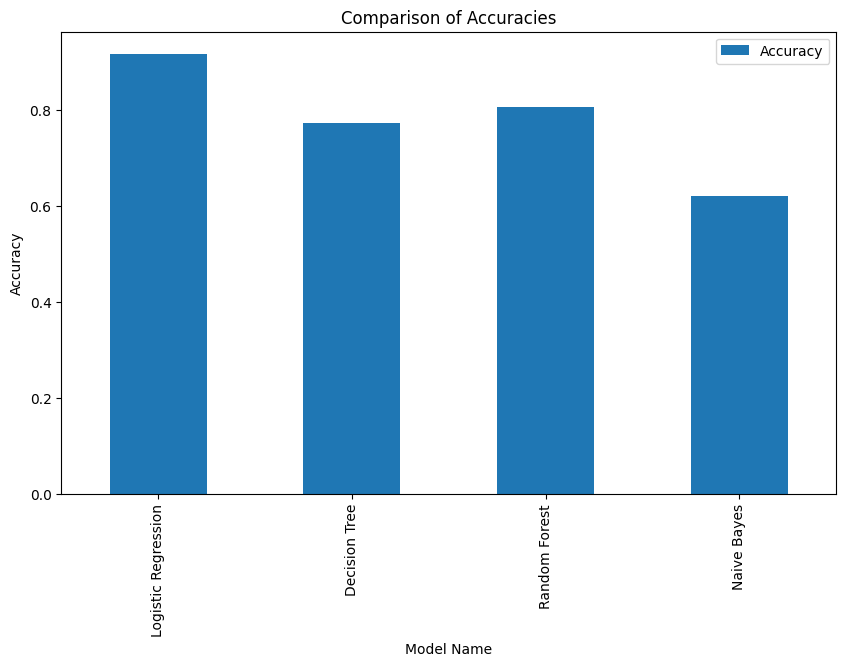

In [104]:
chart = acc_result[['Accuracy']].plot(kind='bar', title="Comparison of Accuracies", figsize=(10, 6))
chart.set_xlabel("Model Name")
chart.set_ylabel("Accuracy")

### It can be seen that logistic regression model has the maximum accuracy among the tried out models and therefore can be used to predict classes of customer complaints

### Testing the model

### Test complaints were prepared to test the classification pattern of the model chosen.

In [105]:
test_complaints = ["I'm urgently reporting the theft of my credit card. Last night, my wallet was stolen from my car. This morning, I discovered multiple unauthorized transactions totaling over $1,500. I've already contacted my bank to freeze the card, but I'm extremely worried about potential identity theft. I need immediate assistance in resolving these fraudulent charges and securing my financial information.", "I'm deeply frustrated with the handling of my home loan application. Despite submitting all required documents over a month ago, the bank has repeatedly requested the same information, causing unnecessary delays. The lack of communication from my assigned loan officer is unacceptable. This process has been unnecessarily stressful and is jeopardizing my home purchase. I demand immediate attention to resolve these issues and expedite my application.", "I'm extremely dissatisfied with the recent changes to my checking account. Without proper notification, the bank increased monthly maintenance fees and lowered the daily ATM withdrawal limit. Additionally, I've noticed unexplained delays in processing my deposits, causing my account to overdraft twice this month. The customer service response has been unhelpful and dismissive. I demand a thorough explanation and immediate resolution of these issues, including refunds for all unwarranted fees.", "I'm writing to express my extreme disappointment with your credit card services. Despite my excellent payment history, my request for a credit limit increase was denied without explanation. Furthermore, the interest rate on my card was suddenly raised by 5%, making it difficult to manage my balance. The rewards program has also been significantly devalued, with point redemption values nearly halved. Your customer service has been unresponsive to my inquiries about these changes. I'm considering closing my account due to these unfair practices."]

### These complaint texts were vectorized using the same TfIDf verctorizer used prior to training the model

In [106]:
X_test = vect.transform(test_complaints)

### Logistic regression model is used to predict the classes of the test complaints

In [107]:
pred_class = logreg.predict(X_test)
pred_class = np.array(pred_class)
pred_class

array([4, 2, 0, 1], dtype=int64)

### The class names are predicted from the numbers from the Topic_names dictionary defined earlier.

In [108]:
for i, complaint in enumerate(test_complaints):
    for key, value in Topic_names.items():
        topic_index = pred_class[i]
        if value == topic_index:
            print("Complaint:", complaint, "\nClass:", key, "\n")

Complaint: I'm urgently reporting the theft of my credit card. Last night, my wallet was stolen from my car. This morning, I discovered multiple unauthorized transactions totaling over $1,500. I've already contacted my bank to freeze the card, but I'm extremely worried about potential identity theft. I need immediate assistance in resolving these fraudulent charges and securing my financial information. 
Class: Theft/Dispute Reporting 

Complaint: I'm deeply frustrated with the handling of my home loan application. Despite submitting all required documents over a month ago, the bank has repeatedly requested the same information, causing unnecessary delays. The lack of communication from my assigned loan officer is unacceptable. This process has been unnecessarily stressful and is jeopardizing my home purchase. I demand immediate attention to resolve these issues and expedite my application. 
Class: Mortgage/Loan 

Complaint: I'm extremely dissatisfied with the recent changes to my chec

### <p style="color: red;">Summary</p>

The following steps were performed
1.  Data loading

2. Text preprocessing, cleaning and lemmatization

3. Exploratory data analysis (EDA)

4. Feature extraction using Tf-Idf

5. Topic modelling using NMF

6. Model building using supervised learning(4 different models: Logistic regression, decision tree, random forest and naive bayes)

7. Model training and evaluation

8. Model inference and choosing the model with the best accuracy metrics

9. Predicting the classes of unseen complaint texts-prepared separately

### <p style="color: red;">It can be found that the classes predicted by the model from the separately prepared test complaint tickets, are accurate.</p>